<a href="https://colab.research.google.com/github/sagek21/dog-generator/blob/master/dog_memorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gzip, pickle
import os
import numpy as np
import pandas as pd
import random
import shutil
import numpy as np
import os

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader


from scipy import linalg
import pathlib
import urllib
import warnings
from PIL import Image
from tqdm import tqdm_notebook as tqdm


import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "XXXXXXXXXXX" 
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXX" # key from the kaggle json file


In [16]:
!kaggle competitions download -c generative-dog-images
## downloading dataset using the kaggle api

 98% 724M/739M [00:03<00:00, 245MB/s]
100% 739M/739M [00:03<00:00, 248MB/s]
Annotation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip Annotation.zip

In [0]:
!unzip all-dogs.zip

In [19]:
!ls

all-dogs  all-dogs.zip	Annotation  Annotation.zip  __MACOSX  sample_data


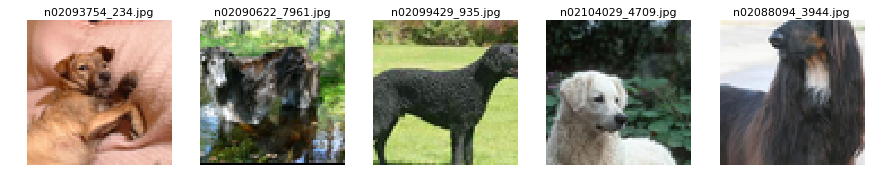

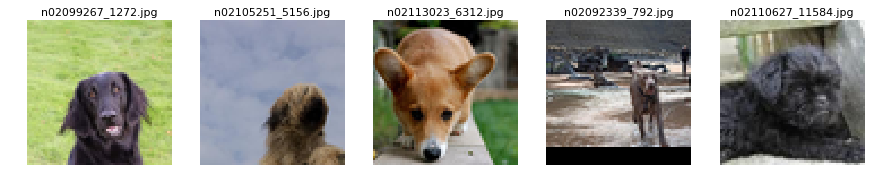

In [40]:
ComputeLB = False
DogsOnly = False 


IMAGES = os.listdir('./all-dogs/')
breeds = os.listdir('./Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP images to only get dogs
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir('./Annotation/'+breed):
            try: img = Image.open('./all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse('./Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    

else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open('./all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(2):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [0]:
class dog_dataset(Dataset):
    def __init__(self, train_y, train_X, zeros, device):
        self.train_y = torch.Tensor(train_y).to(device)
        self.train_X = torch.Tensor(train_X).to(device)
        self.zeros = torch.Tensor(zeros).to(device)
        
    def __len__(self):
        return len(train_y)

    def __getitem__(self, idx):
        return self.train_y[idx], self.train_X[idx], self.zeros[idx]

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
bs = 256

train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

data_set = dog_dataset(train_y, train_X, zeros, device)    
data_loader = DataLoader(data_set, bs)

cuda


In [25]:
##shapes of dataset/train test sets

print(train_y.shape, train_X.shape, zeros.shape)
print(train_y[0].shape, train_X[0].shape, zeros[0].shape)
print(len(train_y), len(train_X), len(zeros))

(10000, 12288) (10000, 10000) (10000, 12288)
(12288,) (10000,) (12288,)
10000 10000 10000


In [0]:
class Discriminator(nn.Module):
    ## first training the discriminator model - classifies generated images as fake or real
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(10000, 12288)
        self.conv1 = nn.Conv2d(1, 1, (2, 1), bias=False)
        
    def forward(self, imgs, imgnames):
        x = self.fc1(imgnames)
        x = torch.sigmoid(x)
        x = torch.cat((imgs, x), dim=1).view(-1, 1, 2, 12288)
        x = self.conv1(x)
        return x.view(-1, 12288)

In [0]:
lr = 0.005
epochs = 360
netD = Discriminator().to(device)
optimizerD = optim.Adam(netD.parameters(), lr=lr)
criteria = nn.BCELoss()
netD.conv1.weight = nn.Parameter(torch.Tensor([[[[ -1.0],
                                    [1.0]]]]).to(device))    
for param in netD.conv1.parameters():
    param.requires_grad = False 

In [28]:
for k in tqdm(range(epochs)):
    for i, (y, X, Zeros) in enumerate(data_loader):
        netD.zero_grad()
        y_pred = netD(Zeros, X)
        loss = criteria(y_pred, y)
        loss.backward()
        optimizerD.step()
    if (k + 1) % 2 == 0:    
        print(f"Epoch: {k+1}/{epochs} | Loss: {loss}")    

Epoch: 2/360 | Loss: 0.6898403167724609
Epoch: 4/360 | Loss: 0.6784372329711914
Epoch: 6/360 | Loss: 0.666438102722168
Epoch: 8/360 | Loss: 0.6550260186195374
Epoch: 10/360 | Loss: 0.6444241404533386
Epoch: 12/360 | Loss: 0.6346046328544617
Epoch: 14/360 | Loss: 0.6255183815956116
Epoch: 16/360 | Loss: 0.6171150207519531
Epoch: 18/360 | Loss: 0.6093450784683228
Epoch: 20/360 | Loss: 0.6021613478660583
Epoch: 22/360 | Loss: 0.595518946647644
Epoch: 24/360 | Loss: 0.5893762707710266
Epoch: 26/360 | Loss: 0.5836942791938782
Epoch: 28/360 | Loss: 0.5784367918968201
Epoch: 30/360 | Loss: 0.5735702514648438
Epoch: 32/360 | Loss: 0.5690639615058899
Epoch: 34/360 | Loss: 0.5648893713951111
Epoch: 36/360 | Loss: 0.5610201358795166
Epoch: 38/360 | Loss: 0.5574323534965515
Epoch: 40/360 | Loss: 0.554103672504425
Epoch: 42/360 | Loss: 0.5510137677192688
Epoch: 44/360 | Loss: 0.5481439232826233
Epoch: 46/360 | Loss: 0.5454768538475037
Epoch: 48/360 | Loss: 0.5429969429969788
Epoch: 50/360 | Loss: 0

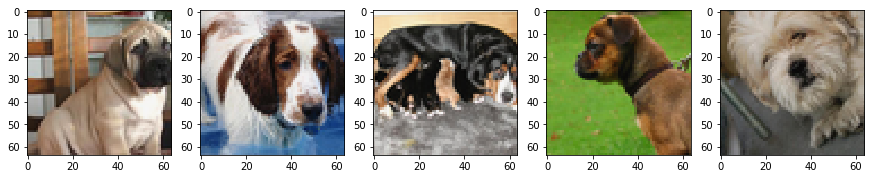

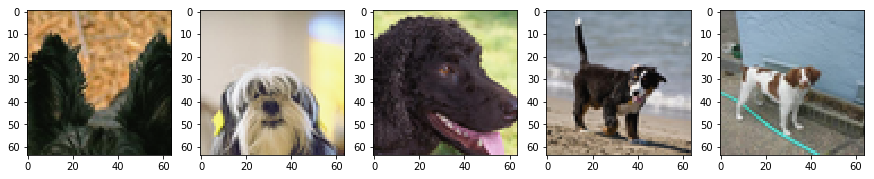

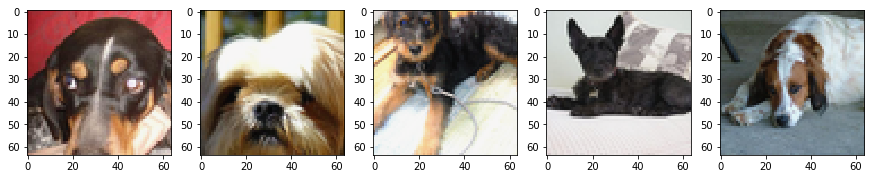

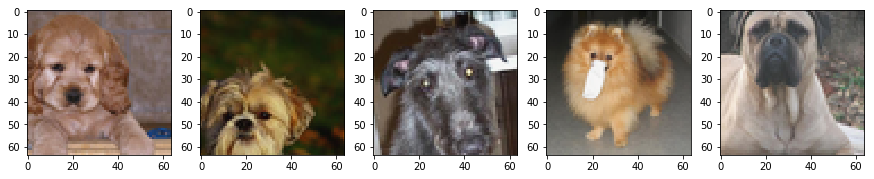

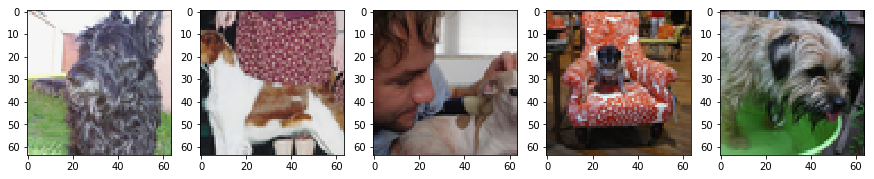

In [29]:
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = torch.Tensor(np.zeros((10000))).to(device)
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
#         img = netD([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = netD(torch.Tensor(zeros[0,:]).to(device).reshape((-1,12288)),xx.reshape((-1,10000))).reshape((-1,64,64,3))
        img = img.detach().cpu().numpy()
        img = Image.fromarray((255 * img).astype('uint8').reshape((64,64,3)))
        plt.imshow(img)
    plt.show()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(10000, 12288)
        
    def forward(self, imgnames):
        x = self.fc1(imgnames)
        return x, imgnames.view(-1, 10000)

In [0]:
def show_image():
    plt.figure(figsize=(15,3))
    for j in range(5):
        with torch.no_grad():
            xx = np.zeros((10000))
            xx[np.random.randint(10000)] = 1
            plt.subplot(1,5,j+1)
            inp = torch.Tensor(xx.reshape((-1,10000))).to(device)
            img = netG(inp)[0].reshape((-1,64,64,3)).to("cpu").clone().detach().numpy()
            img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
            plt.axis('off')
            plt.imshow(img)
    plt.show()  
    
def show_d_images(imgs, title):
    with torch.no_grad():
        imgs = imgs.reshape((-1,64,64,3))
        plt.figure(figsize=(15,3))
        for j in range(5):
            plt.subplot(1,5,j+1)
            img = imgs[j].detach().cpu().numpy()
            img = Image.fromarray((255*img).astype('uint8').reshape((64,64,3)))
            plt.title(title)
            plt.imshow(img)
        plt.show()

In [0]:
lr = 0.01
beta1 = 0.5
netG = Generator().to(device)
optimizerG = optim.Adam(netG.parameters(), lr=lr)
criterion = nn.MSELoss()

netD.conv1.weight = nn.Parameter(torch.Tensor([[[[ -1.],
                                    [1.]]]]).to(device))

# Discriminator is already trained
for param in netD.parameters():
    param.requires_grad = False

Epoch: 5: G_Loss: 0.01851535402238369


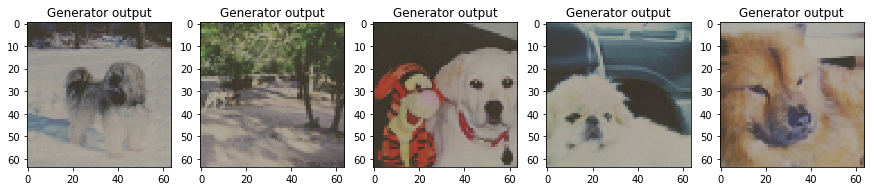

Epoch: 10: G_Loss: 0.0022050903644412756


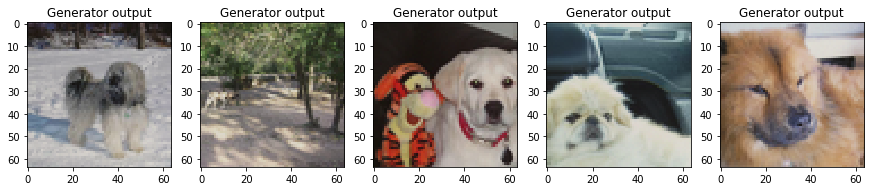

Epoch: 15: G_Loss: 0.00017600500723347068


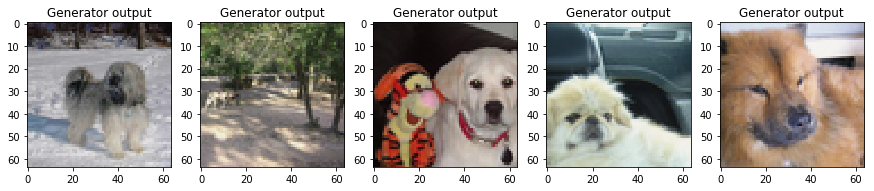

Epoch: 20: G_Loss: 2.4072593078017235e-05


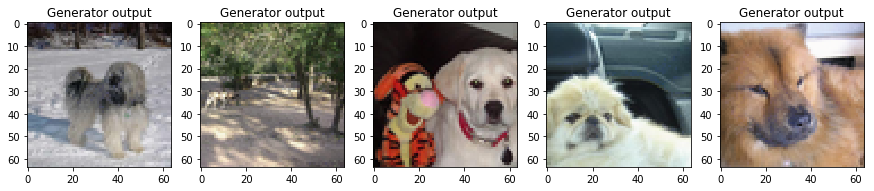

Epoch: 25: G_Loss: 3.590859705582261e-05


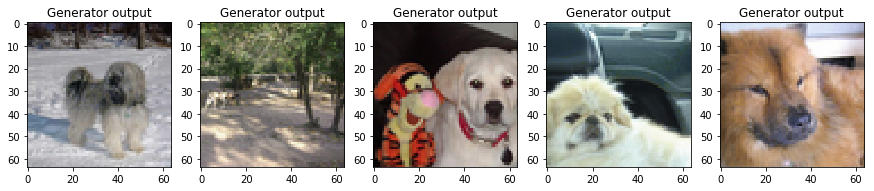

Epoch: 30: G_Loss: 6.979190220590681e-05


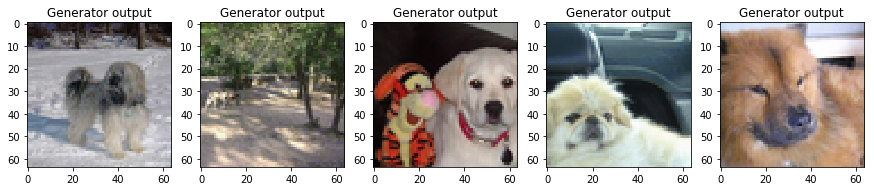

Epoch: 35: G_Loss: 0.00010501081123948097


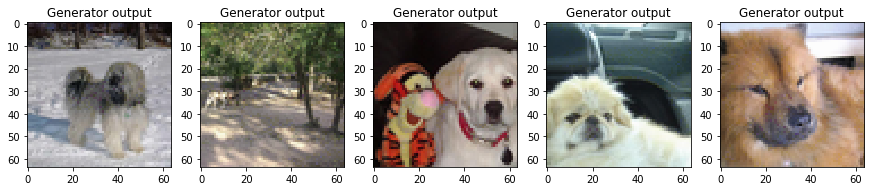

Epoch: 40: G_Loss: 0.00014360134082380682


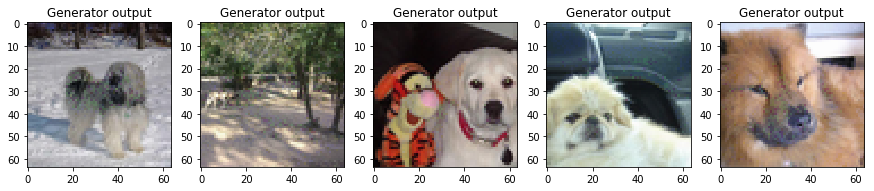

Epoch: 45: G_Loss: 0.00023966310254763812


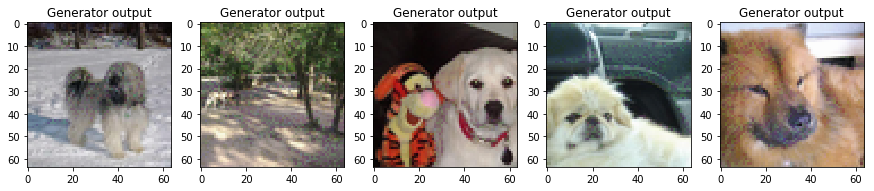

Epoch: 50: G_Loss: 0.0003901206946466118


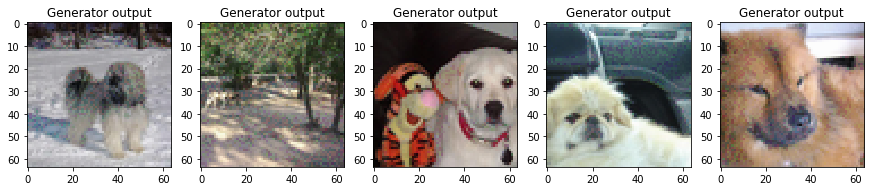

In [33]:
epochs = 50
for epoch in tqdm(range(epochs)):
    for i, (y, X, Zeros) in enumerate(data_loader):
        ############################|
        # (2) Train only the Generator
        ############################
        netG.zero_grad()
        fake, seed = netG(X)
        y_pred = netD(Zeros, seed)
        errG = criterion(fake, y_pred)
        errG.backward()
        optimizerG.step()
    if (epoch+1) % 5 == 0:    
        print(f"Epoch: {epoch+1}: G_Loss: {errG}")
        show_d_images(fake, "Generator output")                

In [0]:
class DogGenerator():
    index = 0   
    t = [
        transforms.RandomCrop((48, 48), padding=None, pad_if_needed=True, fill=0, padding_mode='symmetric'),
        transforms.Resize((64,64))
    ]
    tfms = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ColorJitter(brightness=(1,1.3), contrast=(1,1.3), saturation=0, hue=0)
                               ])
    def getDog(self,seed):
        xx = torch.Tensor(np.zeros((10000))).to(device)
        xx[self.index] = 0.999999
        xx[np.random.randint(10000)] = 0.000001
        img = netG(xx.reshape((-1,10000)))[0].reshape((64,64,3)).detach().cpu().numpy() * 255
        self.index = (self.index+1)%10000
        return self.tfms(Image.fromarray( img.astype('uint8')))

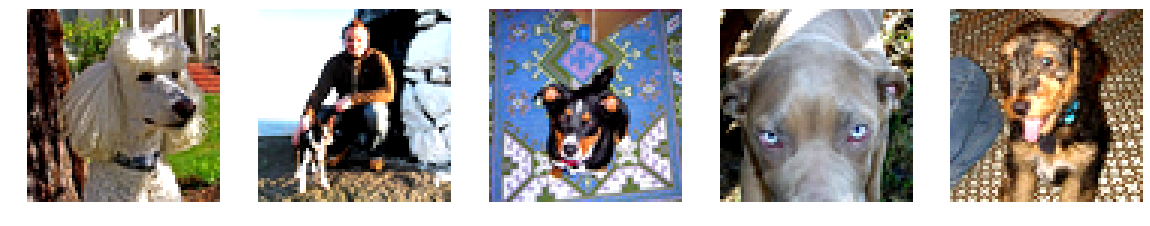

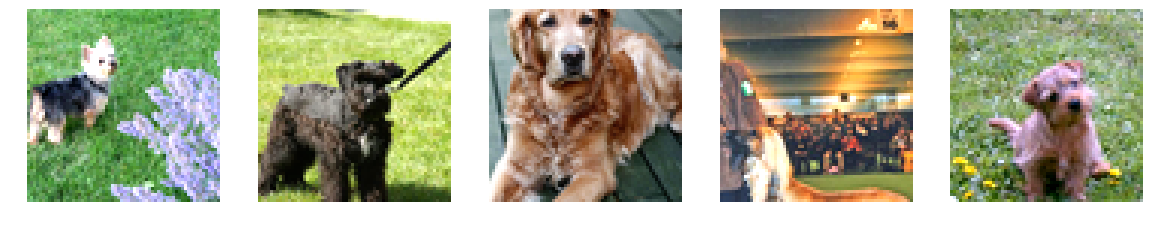

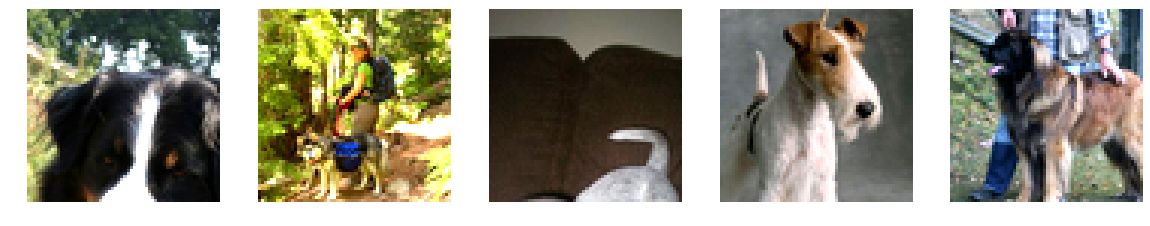

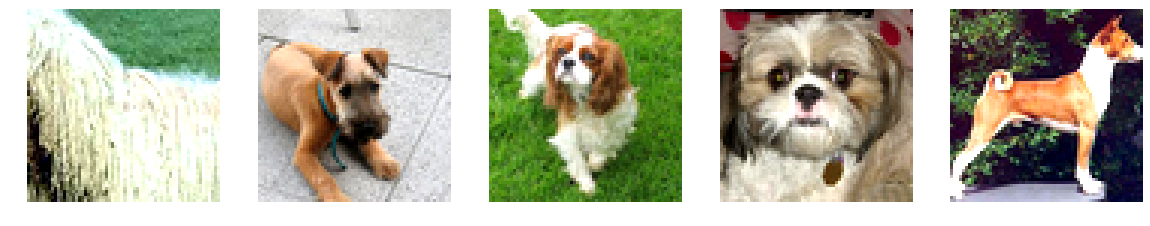

In [39]:
d = DogGenerator()
for k in range(4):
    plt.figure(figsize=(20,5))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = d.getDog(seed = np.random.normal(0,1,100))
        plt.axis('off')
        plt.imshow(img)
    plt.show()